In [1]:
import os
os.chdir('../')

In [2]:
import io

import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import torch
from IPython.display import display
from ipywidgets import HBox
from ipywidgets import Image as ImageWidget
from ipywidgets import Layout, Output
from matplotlib.patches import Patch
from PIL import Image
from scipy.ndimage import gaussian_filter
from scipy.stats import gaussian_kde
from sklearn.manifold import TSNE

from src.DRL.qnetwork import QNetwork
from src.utils import set_size_and_get_figsize
from src.XAI.concept import Concept
from src.XAI.concepts import concept_instances

In [3]:
env_steps = Concept.load_concept_data()
sample_concept = concept_instances['Random continuous']
sample_concept.prepare_data(env_steps)
test_data = sample_concept.test_data
test_images = sample_concept.test_images
test_obs = sample_concept.test_obs

In [4]:
model_path = QNetwork.find_newest_model()
model_path = "runs/20240317-112025/model_10000000.pt"
model = QNetwork(model_path=model_path)
model.eval()
layer = 5

if layer == -1:
    test_acts = test_obs.reshape(test_obs.shape[0], -1)
else:
    q_values, test_acts_dict = model(torch.tensor(test_obs), return_acts=True)
    q_values = q_values.cpu().detach().numpy().mean(axis=1)
    test_acts = test_acts_dict[layer].cpu().detach().numpy()
    test_acts = test_acts.reshape(test_acts.shape[0], -1)

Loaded model: 20240317-112025-10000000


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.008s...
[t-SNE] Computed neighbors for 10000 samples in 3.773s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.930889
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.948051
[t-SNE] KL divergence after 1000 iterations: 1.402319


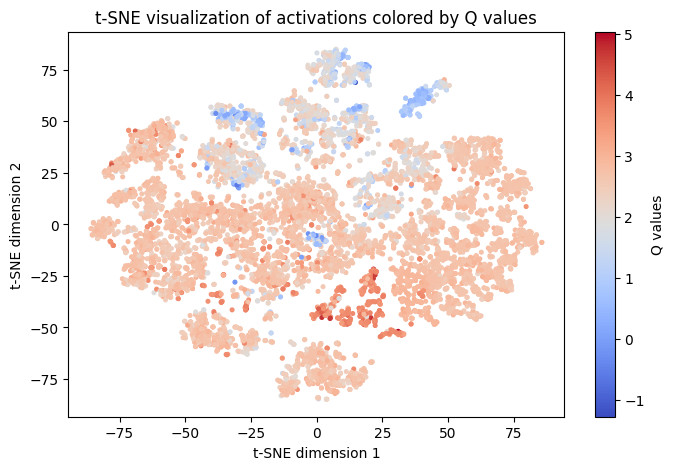

In [5]:
tsne = TSNE(n_components=2, verbose=1)
test_acts_2d = tsne.fit_transform(test_acts)

# Visualizing the activations colored by the corresponding q_values
plt.figure(figsize=(8, 5))
scatter = plt.scatter(test_acts_2d[:, 0], test_acts_2d[:, 1], c=q_values, cmap='coolwarm', s=7)
plt.colorbar(scatter, label='Q values')
plt.title('t-SNE visualization of activations colored by Q values')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()

In [94]:
cool_concepts = [concept_instances['Visible gold coin'], concept_instances['Bullet aligned with player'], concept_instances['Player on grass'], concept_instances['Player in air']]
colors = [(255/255, 240/255, 0),(255/255, 0, 0), (40/255, 200/255, 20/255), (50/255, 120/255, 255/255)]
concept_names = [concept.plot_name for concept in cool_concepts]
data = []
for i in range(len(sample_concept.test_data)):
    present_concepts = []
    for concept in cool_concepts:
        if concept.concept_function(sample_concept.test_data[i].state_variables):
            present_concepts.append(concept.plot_name)
    data.append([test_acts_2d[i][0], test_acts_2d[i][1], present_concepts])

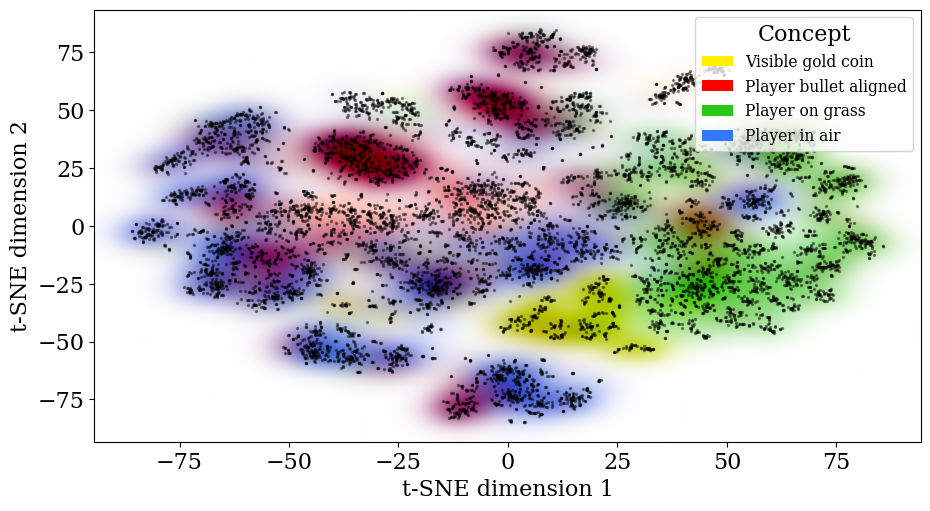

In [95]:
concept_to_index = {concept: idx for idx, concept in enumerate(concept_names)}

x_min, x_max = test_acts_2d[:, 0].min() * 1.1, test_acts_2d[:, 0].max() * 1.1
y_min, y_max = test_acts_2d[:, 1].min() * 1.1, test_acts_2d[:, 1].max() * 1.1
matrix_size = 400

# Define the grid for the matrices
x_bins = np.linspace(x_min, x_max, matrix_size + 1)
y_bins = np.linspace(y_min, y_max, matrix_size + 1)

# Initialize matrices for each concept
heatmaps = [np.zeros((matrix_size, matrix_size)) for _ in concept_names]

# Populate the matrices
for x, y, concepts in data:
    x_index = np.digitize(x, x_bins) - 1
    y_index = np.digitize(y, y_bins) - 1

    for concept in concepts:
        if concept in concept_to_index:
            heatmaps[concept_to_index[concept]][y_index, x_index] += 1

# Smooth and normalize the heatmaps
smoothed_heatmaps = [gaussian_filter(hm, sigma=10) for hm in heatmaps]
normalized_heatmaps = [hm / hm.max() if hm.max() > 0 else hm for hm in smoothed_heatmaps]

# Initialize a composite RGB image
composite_image = np.ones((matrix_size, matrix_size, 3))

# Constructing the composite image by adding weighted colors
for hm, color in zip(normalized_heatmaps, colors):
    for i in range(3):  # RGB channels
        composite_image[:, :, i] += hm * (color[i] - 1)

composite_image = np.clip(composite_image, 0, 1)

fig, ax = plt.subplots(figsize=set_size_and_get_figsize(1))
im = ax.imshow(composite_image, extent=[x_min, x_max, y_min, y_max], origin='lower', aspect='auto')

ax.scatter(test_acts_2d[:, 0], test_acts_2d[:, 1], color='black', s=2, alpha=0.4)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
# ax.set_title('t-SNE activations colored by concept presence')

# Adding custom legend for each concept
legend_elements = [Patch(facecolor=np.array(color), edgecolor='none', label=f'{concept}') for color, concept in zip(colors, concept_names)]
ax.legend(handles=legend_elements, loc='upper right', title='Concept')#, bbox_to_anchor=(1, 1))
#ax.legend(title="Concepts", loc='upper left', )
#plt.axis('off')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.tight_layout()
plt.savefig('figures/concept discovery/tsne on activations.png')
plt.show()

In [24]:
def img_to_displayable(img):
    img_pil = Image.fromarray(img)
    buff = io.BytesIO()
    img_pil.save(buff, format="PNG")
    return buff.getvalue()

# Update the ImageWidget directly instead of displaying a new one
def on_hover(trace, points, state):
    if points.point_inds:
        ind = points.point_inds[0]
        img_data = img_to_displayable(test_images[ind])
        image_widget.value = img_data

In [96]:
colors = []
concept = concept_instances['Visible gold coin']
concept_func = concept.concept_function
for i in range(len(test_data)):
    if concept.binary:
        colors.append(int(concept_func(test_data[i].state_variables)))
    else:
        colors.append(concept_func(test_data[i].state_variables))
colors = np.array(colors)

fig = go.FigureWidget(data=px.scatter(x=test_acts_2d[:, 0], y=test_acts_2d[:, 1], color=colors)
                      .update_traces(marker=dict(size=6, opacity=0.5))
                      .update_layout(width=600, height=500))
image_widget = ImageWidget(format='png', width=84*2, height=84*2)
output_image = Output()

for trace in fig.data:
    trace.on_hover(on_hover)

with output_image:
    display(image_widget)

hbox_layout = HBox([fig, output_image], layout=Layout(align_items='center'))
display(hbox_layout)

    'data': [{'hovertemplate': 'x=%{x}<br>y=%{y}<br>color=%{marker.color}<extra>…